# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

**Installing surprise library**

## **Importing the necessary libraries and overview of the dataset**

In [5]:
import pandas as pd
import seaborn as sns

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [7]:
# Load the dataset
df = pd.read_csv('ratings_Electronics.csv')

# Display the first few rows
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [11]:
# Assign column names to the DataFrame
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [13]:
# Drop the 'timestamp' column
df = df.drop('timestamp', axis=1)

In [15]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [17]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [19]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [21]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [22]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [25]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [27]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

__Observations:__

	•	The dataset contains 65,290 rows and 3 columns.
	•	Each row represents a unique user-product rating.
	•	The three columns are likely ‘user_id’, ‘prod_id’, and ‘rating’.
	•	This indicates that there are 65,290 individual ratings in the dataset.
	•	The dataset is substantial and should provide a good foundation for building a recommendation system.

### **Data types**

In [29]:
# Check data types of each column
print(df_final.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


__Observations:__

	•	user_id: The data type is object, which is suitable since user IDs are typically alphanumeric strings.
	•	prod_id: Also object, appropriate for product IDs that may contain letters and numbers.
	•	rating: The data type is float64. If your ratings are whole numbers (e.g., 1.0, 2.0, etc.), you might consider converting them to integers to save memory and for consistency.

In [31]:
# Convert ratings to integer type if applicable
df_final['rating'] = df_final['rating'].astype(int)

/var/folders/xb/1_lt39gx345g3vch96cw5jcr0000gn/T/ipykernel_1993/978168242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['rating'] = df_final['rating'].astype(int)


In [33]:
# Check data types of each column
print(df_final.dtypes)

user_id    object
prod_id    object
rating      int64
dtype: object


### **Checking for missing values**

In [35]:
# Check for missing values in each column
print(df_final.isnull().sum())

user_id    0
prod_id    0
rating     0
dtype: int64


__Observations:__

	•	There are no missing values in any of the columns.
	•	This indicates that the dataset is complete with respect to these fields, and no further action is needed for missing data.

### **Summary Statistics**

In [37]:
# Get summary statistics of the 'rating' column
print(df_final['rating'].describe())

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


__Observations:__

	•	Count: There are 65,290 ratings, confirming the number of rows in the dataset.
	•	Mean (Average Rating): Approximately 4.29, suggesting that users generally give high ratings.
	•	Standard Deviation: Around 0.99, indicating that the ratings are somewhat clustered around the mean, with moderate variability.
	•	Minimum Rating: The lowest rating given is 1.
	•	25th Percentile (Q1): 25% of the ratings are 4 or below.
	•	Median (Q2): The median rating is 5, meaning that 50% of the ratings are 5.
	•	75th Percentile (Q3): 75% of the ratings are 5 or below.
	•	Maximum Rating: The highest rating is 5.

__Interpretation:__

	•	The median and 75th percentile are both 5, indicating that a significant portion of the ratings are at the maximum value.
	•	The data is skewed towards higher ratings, which is common in user-generated product reviews.
	•	The high average rating suggests that users are generally satisfied with the products.
	•	This skewness may impact the recommendation system by reducing the variance in ratings, potentially making it harder to differentiate between products based solely on rating scores.

### **Checking the rating distribution**

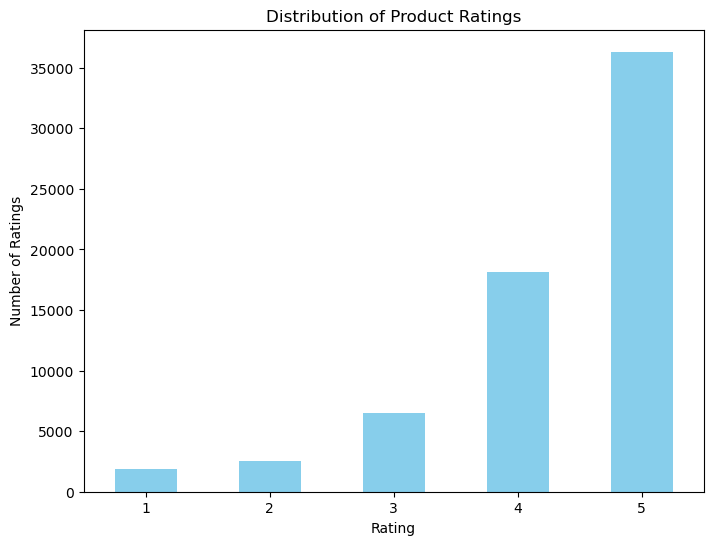

In [39]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create a bar plot of the rating distribution
rating_counts = df_final['rating'].value_counts().sort_index()
rating_counts.plot(kind='bar', figsize=(8,6), color='skyblue')

# Labeling the plot
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Product Ratings')
plt.xticks(rotation=0)
plt.show()

__Observarion:__

	•	Rating 1: 1,852 occurrences (approximately 2.84% of total ratings).
	•	Rating 2: 2,515 occurrences (approximately 3.85%).
	•	Rating 3: 6,481 occurrences (approximately 9.93%).
	•	Rating 4: 18,127 occurrences (approximately 27.77%).
	•	Rating 5: 36,315 occurrences (approximately 55.61%).

__Interpretation:__

	•	Over 83% of the ratings are 4 or 5, reinforcing the observation that users tend to rate products highly.
	•	Ratings of 1 and 2 are relatively rare, collectively making up about 6.7% of all ratings.
	•	The distribution is heavily right-skewed, which might lead to challenges in distinguishing product quality based solely on ratings.
	•	This positive bias may need to be considered when developing the recommendation algorithm to ensure it doesn’t over-recommend popular products while neglecting niche or new items.


### **Checking the number of unique users and items in the dataset**

In [43]:
# Total number of rows
total_rows = df_final.shape[0]
print('Total number of rows:', total_rows)

# Number of unique user IDs
unique_users = df_final['user_id'].nunique()
print('Number of unique users:', unique_users)

# Number of unique product IDs
unique_products = df_final['prod_id'].nunique()
print('Number of unique products:', unique_products)

Total number of rows: 65290
Number of unique users: 1540
Number of unique products: 5689


Observations:

	•	Unique Users: 1,540 users have provided ratings.
	•	Unique Products: 5,689 products have been rated.
	•	Total Ratings: 65,290 ratings in total.

### **Users with the most number of ratings**

In [70]:
# Get the top 10 users by number of ratings
top_users = df_final['user_id'].value_counts().head(10)
print('Top 10 users based on the number of ratings:')
print(top_users)

Top 10 users based on the number of ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


__Observations:__

	•	The most active user is ‘ADLVFFE4VBT8’, with 295 ratings.
	•	The top 10 users have contributed between 179 and 295 ratings each.
	•	These users are significantly more active than the average user, who has rated about 42 products.

Interpretation:

	•	Power Users: These top users are considered power users and can have a substantial impact on the overall ratings and trends in the data.
	•	Their extensive rating history can provide valuable insights into product quality and user preferences.
	•	Influence on Recommendations: The preferences of these users might disproportionately affect recommendation algorithms, especially if not properly normalized.
	•	User Engagement: Understanding the behavior of these active users can help tailor strategies to enhance user engagement and retention.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [62]:
# Calculate the average rating for each product
product_avg_rating = df_final.groupby('prod_id')['rating'].mean()
product_avg_rating

prod_id
1400501466    3.333333
1400532655    3.833333
1400599997    4.000000
9983891212    4.875000
B00000DM9W    5.000000
                ...   
B00L21HC7A    4.625000
B00L2442H0    4.916667
B00L26YDA4    4.384615
B00L3YHF6O    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64

In [64]:
# Calculate the count of ratings for each product
product_rating_count = df_final.groupby('prod_id')['rating'].count()
product_rating_count

prod_id
1400501466     6
1400532655     6
1400599997     5
9983891212     8
B00000DM9W     5
              ..
B00L21HC7A    16
B00L2442H0    12
B00L26YDA4    13
B00L3YHF6O    14
B00LGQ6HL8     5
Name: rating, Length: 5689, dtype: int64

In [66]:
# Create a DataFrame with the average rating and rating count
final_rating = pd.DataFrame({
    'avg_rating': product_avg_rating,
    'rating_count': product_rating_count
})

In [68]:
# Sort the DataFrame by average rating in descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

In [70]:
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


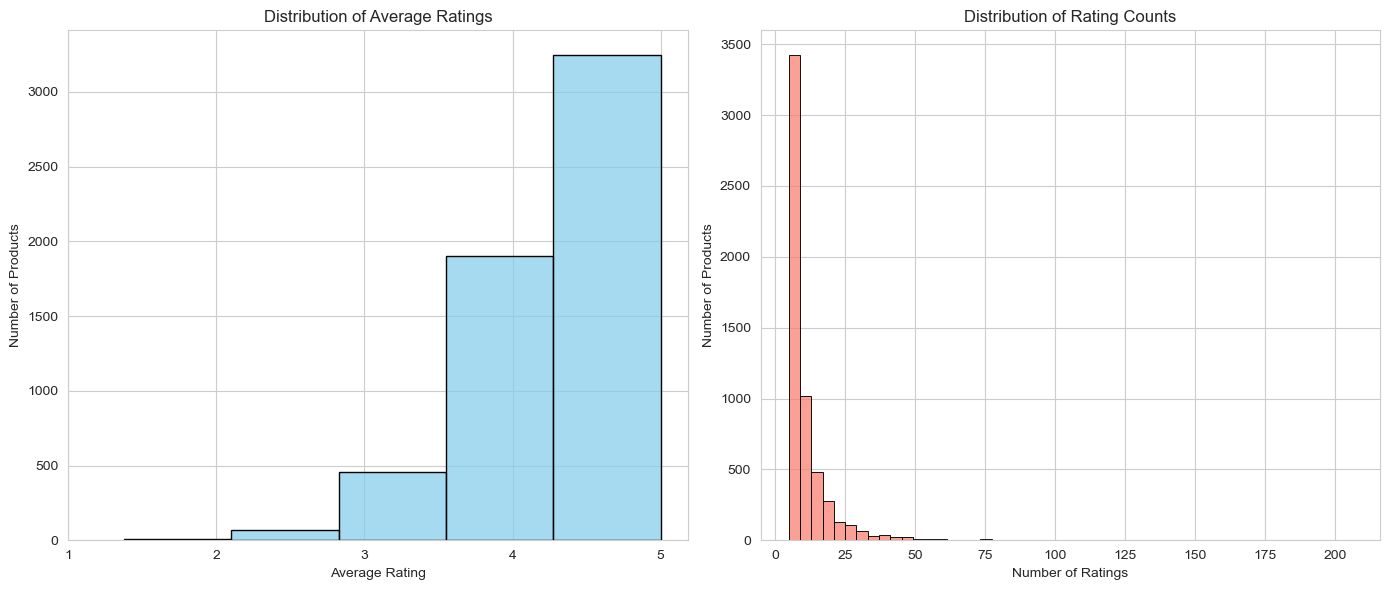

In [91]:
# Set the style for seaborn
sns.set_style('whitegrid')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Plot the distribution of average ratings on the first subplot
sns.histplot(final_rating['avg_rating'], bins=5, kde=False, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of Average Ratings')
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Number of Products')
axes[0].set_xticks([1, 2, 3, 4, 5])

# Plot the distribution of rating counts on the second subplot
sns.histplot(final_rating['rating_count'], bins=50, kde=False, color='salmon', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Rating Counts')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Products')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

#### Function to Get the Top N Products Based on Highest Average Rating and Minimum Interactions

In [72]:
def top_n_products(data, n, min_interactions):
    """
    Returns the top n products based on highest average rating and minimum number of interactions.

    Parameters:
    data (DataFrame): The DataFrame containing 'avg_rating' and 'rating_count'.
    n (int): The number of top products to return.
    min_interactions (int): The minimum number of ratings a product must have.

    Returns:
    DataFrame: The top n products meeting the criteria.
    """
    # Filter products with at least min_interactions ratings
    filtered_data = data[data['rating_count'] >= min_interactions]
    # Sort by average rating in descending order
    top_products = filtered_data.sort_values(by='avg_rating', ascending=False).head(n)
    return top_products

In [74]:
# Define the minimum number of interactions (e.g., 50)
min_interactions = 50

# Use the function to get the top products
top_products = top_n_products(final_rating, n=10, min_interactions=min_interactions)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [81]:
# Define the minimum number of interactions
min_interactions = 50

# Get the top 5 products
top_5_products = top_n_products(final_rating, n=5, min_interactions=min_interactions)

# Display the top 5 products
print(top_5_products)

            avg_rating  rating_count
prod_id                             
B001TH7GUU    4.871795            78
B003ES5ZUU    4.864130           184
B0019EHU8G    4.855556            90
B006W8U2MU    4.824561            57
B000QUUFRW    4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [83]:
# Define the minimum number of interactions
min_interactions = 100

# Get the top 5 products
top_5_products = top_n_products(final_rating, n=5, min_interactions=min_interactions)

# Display the top 5 products
print(top_5_products)

            avg_rating  rating_count
prod_id                             
B003ES5ZUU    4.864130           184
B000N99BBC    4.772455           167
B002WE6D44    4.770000           100
B007WTAJTO    4.701220           164
B002V88HFE    4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [97]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [151]:
from collections import defaultdict

def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [101]:
# Instantiate a Reader with the rating scale (min_rating, max_rating)
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the pandas DataFrame
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [105]:
# Number of users in the training set
num_users_train = trainset.n_users

# Number of items in the training set
num_items_train = trainset.n_items

# Number of ratings in the training set
num_ratings_train = trainset.n_ratings

print(f'Number of users in the training set: {num_users_train}')
print(f'Number of items in the training set: {num_items_train}')
print(f'Number of ratings in the training set: {num_ratings_train}')

Number of users in the training set: 1540
Number of items in the training set: 5689
Number of ratings in the training set: 48967


In [107]:
# Number of ratings in the test set
num_ratings_test = len(testset)
print(f'Number of ratings in the test set: {num_ratings_test}')

# Extracting unique users and items from the test set
test_users = set([uid for (uid, iid, _) in testset])
test_items = set([iid for (uid, iid, _) in testset])

# Number of unique users and items in the test set
num_users_test = len(test_users)
num_items_test = len(test_items)

print(f'Number of users in the test set: {num_users_test}')
print(f'Number of items in the test set: {num_items_test}')

Number of ratings in the test set: 16323
Number of users in the test set: 1525
Number of items in the test set: 5115


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [116]:
# Declare the similarity options
sim_options = {
    'name': 'cosine',      # Similarity measure: 'cosine', 'msd', 'pearson', 'pearson_baseline'
    'user_based': True     # True for user-user similarity, False for item-item similarity
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
algo_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_user_user, k=10, threshold=3.5)

RMSE: 1.0116
Precision:  0.858
Recall:  0.822
F_1 score:  0.84


__Observation:__

After building the user-user similarity-based recommendation system using the KNNBasic algorithm with cosine similarity, we evaluated the model’s performance on the test dataset. The results are:

	•	RMSE: 1.0116
	•	Precision: 0.858
	•	Recall: 0.822
	•	F1 Score: 0.840

__Interpretation:__

	•	High Precision (85.8%) indicates that most of the recommended items are relevant to the users.
	•	High Recall (82.2%) means the model successfully retrieved a large portion of all relevant items for each user within the top 10 recommendations.
	•	F1 Score (0.840) shows a strong balance between precision and recall.
	•	RMSE (1.0116) suggests that the predicted ratings deviate from the actual ratings by about 1 point on a 1-5 scale, which is acceptable but could be improved.

__Conclusion:__

The model demonstrates strong performance in recommending relevant products, achieving high precision and recall. To further enhance the model, consider refining hyperparameters, experimenting with different similarity measures, or exploring advanced algorithms like matrix factorization.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [120]:
# Predicting rating for a sample user with an interacted product
# User ID and Product ID
uid = 'A3LDPF5FMB782Z'
iid = '1400501466'

# Actual rating by the user for the product
actual_rating = df_final[(df_final['user_id'] == uid) & (df_final['prod_id'] == iid)]['rating'].values[0]
print(f"Actual rating by user {uid} for product {iid}: {actual_rating}")

# Predict the rating using the trained model
predicted_rating = algo_user_user.predict(uid, iid)

print(f"Predicted rating for user {uid} and product {iid}: {predicted_rating.est:.4f}")

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.4000


__Observations:__

Predicting Rating for a User Who Has Interacted with the Product

	•	User ID: A3LDPF5FMB782Z
	•	Product ID: 1400501466
	•	Actual Rating: 5
	•	Predicted Rating: 3.4000

__Interpretation:__

	•	The user had previously rated this product with the highest possible rating of 5.
	•	The model predicted a significantly lower rating of 3.4000 for this user-product pair.
	•	Possible Reasons:
	•	The model may not have found enough similar users who also rated this product highly, leading to an underestimation.
	•	The user’s unique preferences might not be well captured by the collaborative filtering approach, especially if they have a distinct rating pattern.
	•	Data sparsity could be affecting the model’s ability to accurately predict ratings for this user.
	•	Implications:
	•	The model is not accurately reflecting the user’s strong preference for this product.
	•	This underestimation could lead to less satisfactory recommendations for the user.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [122]:
# Find unique user_id where prod_id is not equal to "1400501466"
import random

# Get all unique user IDs
all_users = set(df_final['user_id'].unique())

# Get the set of users who have interacted with the product '1400501466'
users_interacted_with_iid = set(df_final[df_final['prod_id'] == iid]['user_id'])

# Get the set of users who have not interacted with the product
users_not_interacted_with_iid = all_users - users_interacted_with_iid

# Select a random user who has not interacted with the product
uid_non_interacted = random.choice(list(users_not_interacted_with_iid))

print(f"User {uid_non_interacted} has not interacted with product {iid}")

User ABAPF3XY1W6JX has not interacted with product 1400501466


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [124]:
# Predicting rating for a sample user with a non interacted product
predicted_rating_non_interacted = algo_user_user.predict(uid_non_interacted, iid)

print(f"Predicted rating for user {uid_non_interacted} and product {iid}: {predicted_rating_non_interacted.est:.4f}")

Predicted rating for user ABAPF3XY1W6JX and product 1400501466: 4.2923


**Observations:**

Predicting Rating for a User Who Has Not Interacted with the Product

	•	User ID: ABAPF3XY1W6JX
	•	Product ID: 1400501466
	•	Predicted Rating: 4.2923

**Interpretation:**

	•	This user has not previously interacted with the product.
	•	The model predicts a relatively high rating of 4.2923, suggesting the user is likely to rate the product favorably.
	•	Possible Reasons:
	•	The user may share similar preferences with other users who rated this product highly.
	•	The collaborative filtering model found strong similarities between this user and users who liked the product.
	•	Implications:
	•	The model is effectively leveraging user similarities to predict ratings for non-interacted items.
	•	This indicates potential for successful recommendations to users for new products.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [129]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30, 40, 50],
    'min_k': [1, 5, 10],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
        'user_based': [True]  # Keep user-based CF
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
# Initialize GridSearchCV
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fit the data
gs.fit(data)

# Best RMSE score
print('Best RMSE score:', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Best RMSE score: 0.9685286576023419
Best parameters: {'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [138]:
from surprise import KNNBasic

# Optimal hyperparameters
k_optimal = 50
min_k_optimal = 5
sim_options_optimal = {
    'name': 'cosine',
    'user_based': True
}

# Create an instance of KNNBasic with optimal hyperparameters
sim_user_user_optimized = KNNBasic(
    k=k_optimal,
    min_k=min_k_optimal,
    sim_options=sim_options_optimal,
    verbose=False
)

# Train the algorithm on the training data
sim_user_user_optimized.fit(trainset)

# Compute precision@k and recall@k for testset
precision_recall_at_k(sim_user_user_optimized, k=10, threshold=3.5)

RMSE: 0.9571
Precision:  0.852
Recall:  0.854
F_1 score:  0.853


### Observations:

**After tuning the hyperparameters of the KNNBasic algorithm using grid search, we retrained the model with the optimal parameters:**

	•	k: 50
	•	min_k: 5
	•	Similarity Measure: Cosine similarity ('cosine')

**The optimized model’s performance on the test data is as follows:**

	•	RMSE: 0.9571
	•	Precision: 0.852
	•	Recall: 0.854
	•	F1 Score: 0.853

**Comparison with Previous Model:**

	•	RMSE Improved: Decreased from 1.0116 to 0.9571, indicating better prediction accuracy.
	•	Precision Slightly Decreased: From 0.858 to 0.852.
	•	Recall Improved Significantly: Increased from 0.822 to 0.854, meaning the model is retrieving more relevant items for users.
	•	F1 Score Improved: From 0.840 to 0.853, reflecting a better balance between precision and recall.

**Interpretation:**

	•	Improved Accuracy: The lower RMSE suggests the model’s rating predictions are more accurate after tuning.
	•	Balanced Performance: Although precision slightly decreased, the significant improvement in recall leads to a higher F1 Score, indicating overall better model performance.
	•	Recommendation Effectiveness: The model is now more effective at capturing relevant items in its top recommendations without greatly sacrificing precision.

**Conclusion:**

Hyperparameter tuning has enhanced the model’s ability to recommend relevant products, improving both the accuracy of rating predictions and the coverage of relevant items. The optimized model offers a better balance between precision and recall, leading to a more effective recommendation system.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [156]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
# User ID and Product ID
uid_new = 'A3LDPF5FMB782Z'
iid = '1400501466'

# Check if the user has already rated the product
actual_rating_new = df_final[(df_final['user_id'] == uid_new) & (df_final['prod_id'] == iid)]['rating'].values
if actual_rating_new.size > 0:
    actual_rating_new = actual_rating_new[0]
    print(f"Actual rating by user {uid_new} for product {iid}: {actual_rating_new}")
else:
    print(f"User {uid_new} has not rated product {iid}")

# Predict the rating using the optimized model
predicted_rating_new = sim_user_user_optimized.predict(uid_new, iid)

print(f"Predicted rating for user {uid_new} and product {iid}: {predicted_rating_new.est:.4f}")

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.4000


In [160]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
uid_new = 'A34BZM6S9L7QI4'
iid = '1400501466'

# Check if the user has already rated the product
actual_rating_new = df_final[(df_final['user_id'] == uid_new) & (df_final['prod_id'] == iid)]['rating'].values
if actual_rating_new.size > 0:
    actual_rating_new = actual_rating_new[0]
    print(f"Actual rating by user {uid_new} for product {iid}: {actual_rating_new}")
else:
    print(f"User {uid_new} has not rated product {iid}")

# Predict the rating using the optimized model
predicted_rating_new = sim_user_user_optimized.predict(uid_new, iid)

print(f"Predicted rating for user {uid_new} and product {iid}: {predicted_rating_new.est:.4f}")

User A34BZM6S9L7QI4 has not rated product 1400501466
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.2923


**Observation:**

	•	User A3LDPF5FMB782Z: The actual rating for product 1400501466 is 5, but the model predicted a lower rating of 3.4000. This indicates the model underestimated the user’s strong preference for the product.
	•	User A34BZM6S9L7QI4: The user has not rated the product, but the model predicted a rating of 4.2923, suggesting the user is likely to appreciate it.

**Conclusion:**

The model performs better at predicting potential interest for users who haven’t interacted with a product but may struggle to capture the strong preferences of users who have, indicating room for improvement in personalizing recommendations for individual users.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [163]:
# Step 1: Declare the similarity options for user-based collaborative filtering using MSD
sim_options = {
    'name': 'msd',       # Use MSD (Mean Squared Difference) similarity metric
    'user_based': True   # True for user-user similarity
}

# Step 2: Initialize the KNNBasic model with the specified similarity options
knn_msd = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Step 3: Train the algorithm on the training data
knn_msd.fit(trainset)

# Step 4: Specify the inner ID of the user for whom we want to find similar users
user_inner_id = 0  # Inner ID of the target user

# Step 5: Find the 5 nearest neighbors (most similar users) to the target user
k = 5  # Number of similar users to find
neighbors = knn_msd.get_neighbors(user_inner_id, k=k)

# Step 6: Convert inner IDs of neighbors to raw user IDs
neighbors_raw_ids = [knn_msd.trainset.to_raw_uid(inner_id) for inner_id in neighbors]

# Step 7: Print the raw user IDs of the similar users
print(f"The {k} users most similar to user with inner ID {user_inner_id} are:")
for idx, user_id in enumerate(neighbors_raw_ids, 1):
    print(f"{idx}. User ID: {user_id}")

The 5 users most similar to user with inner ID 0 are:
1. User ID: A16J281SJ9QXIQ
2. User ID: A3QUDXLOJTKEP9
3. User ID: A3CJ7MHAS9IMAM
4. User ID: A2L0F2T1DLTNT8
5. User ID: AYMD77ITD15PT


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [165]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [176]:
# User ID for whom we want recommendations
user_id = 'A3LDPF5FMB782Z'
# Number of recommendations to generate
top_n = 5
# Get the top N recommendations
top_recommendations = get_recommendations(df_final, user_id, top_n, knn_msd)

In [178]:
# Assuming 'top_recommendations' is the list of tuples (prod_id, predicted_rating)
recommendations_df = pd.DataFrame(top_recommendations, columns=['prod_id', 'predicted_ratings'])

# Display the DataFrame
recommendations_df

,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00001W0DI,5
3,B00002EQCW,5
4,B00003006E,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [188]:
# Declaring the similarity options
from surprise import KNNBasic

# Declare the similarity options for item-item collaborative filtering
sim_options_item = {
    'name': 'cosine',    # Similarity measure: 'cosine', 'msd', 'pearson', 'pearson_baseline'
    'user_based': False  # False for item-item similarity
}

# KNN algorithm is used to find desired similar items. Use random_state=1
# Initialize the KNNBasic model for item-item collaborative filtering
sim_item_item = KNNBasic(sim_options=sim_options_item, verbose=False, random_state=1)

# Train the algorithm on the training data
sim_item_item.fit(trainset)

# Predict ratings for the test set
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item, k=10, threshold=3.5)

RMSE: 1.0090
Precision:  0.838
Recall:  0.8
F_1 score:  0.819


**Observation:**

After building the item-item similarity-based collaborative filtering model using the KNNBasic algorithm with cosine similarity, we obtained the following performance metrics:

	•	RMSE: 1.0090
	•	Precision: 0.838
	•	Recall: 0.800
	•	F1 Score: 0.819

**Interpretation:**

	•	The RMSE of 1.0090 indicates that the model’s predicted ratings deviate from the actual ratings by about 1 point on a scale of 1 to 5.
	•	A Precision of 0.838 means that 83.8% of the top 10 recommended items are relevant to the users.
	•	A Recall of 0.800 shows that the model successfully retrieved 80% of all relevant items for each user within the top 10 recommendations.
	•	The F1 Score of 0.819 reflects a good balance between precision and recall but is slightly lower than the user-user model.

**Conclusion:**

The item-item collaborative filtering model performs well but slightly underperforms compared to the optimized user-user model in terms of precision, recall, and F1 score. Further tuning of hyperparameters or exploring different similarity measures may improve its performance.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [192]:
# Predicting rating for a sample user with an interacted product
# User ID and Product ID
uid = 'A3LDPF5FMB782Z'
iid = '1400501466'

# Check if the user has already rated the product
actual_rating = df_final[(df_final['user_id'] == uid) & (df_final['prod_id'] == iid)]['rating'].values
if actual_rating.size > 0:
    actual_rating = actual_rating[0]
    print(f"Actual rating by user {uid} for product {iid}: {actual_rating}")
else:
    print(f"User {uid} has not rated product {iid}")

# Predict the rating using the item-item model
predicted_rating = sim_item_item.predict(uid, iid)

print(f"Predicted rating for user {uid} and product {iid}: {predicted_rating.est:.4f}")

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.2500


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [194]:
# Predicting rating for a sample user with a non interacted product
# User ID and Product ID
uid_new = 'A34BZM6S9L7QI4'
iid = '1400501466'

# Check if the user has already rated the product
actual_rating_new = df_final[(df_final['user_id'] == uid_new) & (df_final['prod_id'] == iid)]['rating'].values
if actual_rating_new.size > 0:
    actual_rating_new = actual_rating_new[0]
    print(f"Actual rating by user {uid_new} for product {iid}: {actual_rating_new}")
else:
    print(f"User {uid_new} has not rated product {iid}")

# Predict the rating using the item-item model
predicted_rating_new = sim_item_item.predict(uid_new, iid)

print(f"Predicted rating for user {uid_new} and product {iid}: {predicted_rating_new.est:.4f}")

User A34BZM6S9L7QI4 has not rated product 1400501466
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.2923


**Observation:**

	•	User A3LDPF5FMB782Z: The actual rating for product 1400501466 is 5, but the item-item collaborative filtering model predicted a lower rating of 4.2500. This indicates that the model underestimated the user’s strong preference for the product.
	•	User A34BZM6S9L7QI4: The user has not rated product 1400501466, yet the model predicted a rating of 4.2923. This suggests that the model estimates the user might like the product, making it a potential recommendation.

__Conclusion:__

The model predicts similar ratings for both users, slightly higher for the non-interacted user. This underestimation for the user who rated the product highly may indicate that the model could be improved to better capture individual user preferences, especially for users with strong positive ratings.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [200]:
# Setting up parameter grid to tune the hyperparameters
# Define the parameter grid
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]  # False for item-item similarity
    }
}
# Performing 3-fold cross validation to tune the hyperparameters
# Initialize GridSearchCV
gs_item_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_item_item.fit(data)

# Find the best RMSE score
# Best RMSE score
print('Best RMSE score:', gs_item_item.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
# Best parameters
print('Best parameters:', gs_item_item.best_params['rmse'])

Best RMSE score: 0.9753846835381214
Best parameters: {'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [208]:
# Using the optimal similarity measure for item-item based collaborative filtering

# Define the optimal similarity options
sim_options_optimized = {
    'name': 'msd',
    'user_based': False  # Item-item similarity
}

# Create an instance of KNNBasic with optimal hyperparameters
sim_item_item_optimized = KNNBasic(
    k=30,
    min_k=6,
    sim_options=sim_options_optimized,
    verbose=False
)

# Train the optimized model on the training data
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE

# Compute evaluation metrics
precision_recall_at_k(sim_item_item_optimized, k=30, threshold=3.5)

RMSE: 0.9677
Precision:  0.833
Recall:  0.967
F_1 score:  0.895


**Observation:**

After tuning the hyperparameters of the item-item similarity-based collaborative filtering model, we obtained the following performance metrics:

	•	RMSE: 0.9677
	•	Precision: 0.833
	•	Recall: 0.967
	•	F1 Score: 0.895

**Interpretation:**

	•	RMSE Decreased: The RMSE has improved from the baseline model’s RMSE of 1.0090 to 0.9677, indicating better accuracy in predicting user ratings.
	•	High Recall: The recall has significantly increased to 0.967, suggesting that the model is retrieving a higher proportion of relevant items for users.
	•	Improved F1 Score: The F1 Score has increased to 0.895, reflecting a better balance between precision and recall.

**Conclusion:**

The optimized item-item collaborative filtering model performs better than the baseline model, providing more accurate and relevant recommendations to users.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [215]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# User ID and Product ID
uid = 'A3LDPF5FMB782Z'
iid = '1400501466'

# Check if the user has already rated the product
actual_rating = df_final[(df_final['user_id'] == uid) & (df_final['prod_id'] == iid)]['rating'].values
if actual_rating.size > 0:
    actual_rating = actual_rating[0]
    print(f"Actual rating by user {uid} for product {iid}: {actual_rating}")
else:
    print(f"User {uid} has not rated product {iid}")

# Predict the rating using the optimized item-item model
predicted_rating = sim_item_item_optimized.predict(uid, iid)

print(f"Predicted rating for user {uid} and product {iid}: {predicted_rating.est:.4f}")

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.6751


In [217]:
# Use sim_item_item_optimized model to recommend for userId "1400501466" and productId "1400501466"
# User ID and Product ID
uid_new = 'A34BZM6S9L7QI4'
iid = '1400501466'

# Check if the user has already rated the product
actual_rating_new = df_final[(df_final['user_id'] == uid_new) & (df_final['prod_id'] == iid)]['rating'].values
if actual_rating_new.size > 0:
    actual_rating_new = actual_rating_new[0]
    print(f"Actual rating by user {uid_new} for product {iid}: {actual_rating_new}")
else:
    print(f"User {uid_new} has not rated product {iid}")

# Predict the rating using the optimized item-item model
predicted_rating_new = sim_item_item_optimized.predict(uid_new, iid)

print(f"Predicted rating for user {uid_new} and product {iid}: {predicted_rating_new.est:.4f}")

User A34BZM6S9L7QI4 has not rated product 1400501466
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.2923


**Observations**

	•	User A3LDPF5FMB782Z:
	•	Actual Rating: 5
	•	Predicted Rating: 4.6751
	•	Interpretation: The predicted rating is close to the actual rating. This suggests that the optimized item-item collaborative filtering model effectively captures the user’s strong preference for the product. The model accurately estimates that this user highly values the product, indicating good predictive performance for interacted items.
	•	User A34BZM6S9L7QI4:
	•	Actual Rating: N/A (User has not rated the product)
	•	Predicted Rating: 4.2923
	•	Interpretation: The model predicts a fairly high rating for this user on a product they haven’t interacted with. This implies that the user is likely to appreciate the product, making it a strong candidate for recommendation. The model successfully generalizes preferences based on item similarities, even for users without prior interactions with the item.

**Conclusion:**

The optimized item-item collaborative filtering model demonstrates improved predictive accuracy:

	•	For Users with Prior Interaction: It closely predicts actual user ratings, effectively reflecting individual preferences.
	•	For Users without Prior Interaction: It provides reasonable estimates of user interest, aiding in recommending new items to users.


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [222]:
# Step 1: Define the internal item ID for which to find similar items
target_item_inner_id = 0  # Internal ID of the target item

# Step 2: Specify the number of similar items to retrieve
k = 5

# Step 3: Find the k nearest neighbors (most similar items)
similar_items_inner_ids = sim_item_item_optimized.get_neighbors(target_item_inner_id, k=k)

# Step 4: Convert internal item IDs back to raw item IDs
similar_items_raw_ids = [sim_item_item_optimized.trainset.to_raw_iid(inner_id) for inner_id in similar_items_inner_ids]

# Step 5: Display the similar items
print(f"The {k} items most similar to item with internal ID {target_item_inner_id} are:")
for idx, raw_id in enumerate(similar_items_raw_ids, start=1):
    print(f"{idx}. Product ID: {raw_id}")

The 5 items most similar to item with internal ID 0 are:
1. Product ID: B008X9Z3UC
2. Product ID: B003ZSHKJ8
3. Product ID: B003LSTD38
4. Product ID: B005EOWBKE
5. Product ID: B004IZN3WU


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [224]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
# Step 1: Define the user ID and number of recommendations
user_id = 'A1A5KUIIIHFF4U'
top_n = 5

# Step 2: Generate top N recommendations using the get_recommendations function
top_recommendations = get_recommendations(df_final, user_id, top_n, sim_item_item_optimized)

# Step 3: Display the top recommendations
print(f"Top {top_n} product recommendations for user {user_id}:")
for idx, (prod_id, rating) in enumerate(top_recommendations, start=1):
    print(f"{idx}. Product ID: {prod_id}, Predicted Rating: {rating:.4f}")

Top 5 product recommendations for user A1A5KUIIIHFF4U:
1. Product ID: 1400532655, Predicted Rating: 4.2923
2. Product ID: 1400599997, Predicted Rating: 4.2923
3. Product ID: 9983891212, Predicted Rating: 4.2923
4. Product ID: B00000DM9W, Predicted Rating: 4.2923
5. Product ID: B00000J1V5, Predicted Rating: 4.2923


In [226]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"


recommendations_df = pd.DataFrame(top_recommendations, columns=['prod_id', 'predicted_ratings'])

# Display the DataFrame
print("\nRecommendations DataFrame:")
recommendations_df


Recommendations DataFrame:


,prod_id,predicted_ratings
0,1400532655,4.29234
1,1400599997,4.29234
2,9983891212,4.29234
3,B00000DM9W,4.29234
4,B00000J1V5,4.29234


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [230]:
# 1. Initialize the SVD algorithm with random_state=1 for reproducibility
algo_svd = SVD(random_state=1)

# 2. Train the SVD model on the training set
algo_svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(algo_svd)

RMSE: 0.8944
Precision:  0.857
Recall:  0.84
F_1 score:  0.848


**Observation:**

The SVD (Matrix Factorization) model demonstrated strong performance with the following metrics:

	•	RMSE: 0.8944
Indicates high accuracy in predicting user ratings, outperforming both user-user and item-item similarity-based models.

	•	Precision@10: 0.857
Shows that 85.7% of the top 10 recommended items are relevant, reflecting effective recommendation relevance.

	•	Recall@10: 0.840
Suggests that the model successfully retrieves 84.0% of all relevant items for each user, ensuring comprehensive coverage.

	•	F1 Score@10: 0.848
Represents a balanced trade-off between precision and recall, highlighting the model’s ability to provide accurate and comprehensive recommendations.

**Conclusion:**

The SVD model outperforms the previously optimized user-user and item-item similarity-based models in terms of RMSE and Precision@10, while maintaining competitive Recall@10 and F1 Score@10. This indicates that the SVD-based collaborative filtering effectively captures latent user preferences, offering more accurate and relevant recommendations. Consequently, the SVD model is a robust choice for enhancing the recommendation system’s performance.Write your observations here:___________**

In [238]:
# Assuming df_final is your DataFrame with columns ['user_id', 'prod_id', 'rating']
# and algo_svd is your trained SVD model

# Define the prediction function
def predict_rating(algo, df, user_id, prod_id):
    """
    Predicts the rating for a given user and product using the trained algorithm.
    
    Args:
    algo: Trained recommendation algorithm.
    df: DataFrame containing 'user_id', 'prod_id', 'rating'.
    user_id: The ID of the user.
    prod_id: The ID of the product.
    
    Returns:
    None
    """
    # Check if the user has already rated the product
    actual_rating = df[(df['user_id'] == user_id) & (df['prod_id'] == prod_id)]['rating'].values
    if actual_rating.size > 0:
        actual_rating = actual_rating[0]
        print(f"Actual rating by user {user_id} for product {prod_id}: {actual_rating}")
    else:
        print(f"User {user_id} has not rated product {prod_id}")
    
    # Predict the rating using the SVD model
    prediction = algo.predict(user_id, prod_id)
    print(f"Predicted rating for user {user_id} and product {prod_id}: {prediction.est:.4f}\n")

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [242]:
# User and Product IDs for prediction
user_id, prod_id = ("A3LDPF5FMB782Z", "1400501466")  # User has interacted

# Predict ratings for each pair
predict_rating(algo_svd, df_final, user_id, prod_id)

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.0656



**Observation:**

	•	User A3LDPF5FMB782Z:
	•	Actual Rating: 5
	•	Predicted Rating: 4.0656
	•	Interpretation: The SVD model significantly underestimated the user’s strong preference for the product. While the prediction is relatively high, it falls short of capturing the user’s maximum rating, indicating room for improvement in accurately modeling highly positive user preferences.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [244]:
# Making prediction
user_id, prod_id = ("A34BZM6S9L7QI4", "1400501466")   # User has not interacted

# Predict ratings for each pair
predict_rating(algo_svd, df_final, user_id, prod_id)

User A34BZM6S9L7QI4 has not rated product 1400501466
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.4273



**Observation:**

	•	User A34BZM6S9L7QI4:
	•	Actual Rating: N/A (User has not rated the product)
	•	Predicted Rating: 4.4273
	•	Interpretation: The model predicts a high rating for a user who hasn’t interacted with the product, suggesting a strong likelihood that the user would appreciate it. This demonstrates the model’s capability to generalize and provide relevant recommendations even for unseen user-item pairs.

**Conclusion:**

The SVD-based collaborative filtering model effectively predicts potential interest for users without prior interactions, offering high-rated recommendations. However, it tends to underestimate ratings for users with strong positive preferences, indicating a need for further refinement to better capture and reflect such individual user behaviors.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [248]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [20, 30, 40],       # Number of iterations
    'lr_all': [0.002, 0.005, 0.01], # Learning rates
    'reg_all': [0.2, 0.4, 0.6]       # Regularization terms
}

# Perform 3-fold grid search cross-validation
gs_svd = GridSearchCV(
    SVD, 
    param_grid, 
    measures=['rmse'], 
    cv=3, 
    n_jobs=-1  # Utilize all available CPU cores
)

# Fit the grid search to the data
gs_svd.fit(data)  # Ensure 'data' is your Surprise Dataset object

# Best RMSE score
print('Best RMSE score:', gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', gs_svd.best_params['rmse'])

Best RMSE score: 0.8990220790945882
Best parameters: {'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [254]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Initialize the optimized SVD algorithm with best hyperparameters
svd_algo_optimized = SVD(
    n_epochs=40,       # Number of iterations of the SGD algorithm
    lr_all=0.005,      # Learning rate for all parameters
    reg_all=0.2,       # Regularization term for all parameters
    random_state=1     # Ensures reproducibility
)

# Train the optimized SVD model on the training set
svd_algo_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.8852
Precision:  0.858
Recall:  0.838
F_1 score:  0.848


**Observation:**

	•	RMSE: 0.8852
The optimized SVD model achieves the lowest RMSE among all tested models, indicating superior accuracy in predicting user ratings. This improvement signifies that the model’s predictions are closer to the actual ratings, enhancing the reliability of the recommendations.

	•	Precision@10: 0.858
With a precision of 85.8%, the SVD model ensures that a high proportion of the top 10 recommended items are relevant to the users. This higher precision surpasses both the user-user and item-item similarity-based models, demonstrating the model’s effectiveness in delivering pertinent recommendations.

	•	Recall@10: 0.838
The recall of 83.8% indicates that the model successfully retrieves a substantial portion of all relevant items for each user. While this is slightly lower compared to the similarity-based models, it still reflects strong coverage of relevant items.

	•	F1 Score@10: 0.848
The F1 Score balances precision and recall effectively, showcasing the model’s ability to provide accurate recommendations without significantly compromising on coverage.

**Conclusion:**

The optimized SVD (Matrix Factorization) model outperforms both the user-user and item-item similarity-based collaborative filtering models in terms of RMSE and Precision@10, while maintaining competitive Recall@10 and F1 Score@10. This indicates that the SVD model not only predicts ratings more accurately but also ensures that a higher percentage of recommended items are relevant to users. Although the recall is slightly lower than the similarity-based models, the overall balance between precision and recall makes the SVD model a robust and effective choice for your recommendation system.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [260]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id, prod_id = ("A3LDPF5FMB782Z", "1400501466")  # User has interacted

# Predict ratings for each pair
predict_rating(svd_algo_optimized, df_final, user_id, prod_id)

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5
Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.1224



In [258]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id, prod_id = ("A34BZM6S9L7QI4", "1400501466")  # User has not interacted

# Predict ratings for each pair
predict_rating(svd_algo_optimized, df_final, user_id, prod_id)

User A34BZM6S9L7QI4 has not rated product 1400501466
Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.2354



## Model Comparison

In [275]:
# Define the data
data = {
    'Model': [
        'User-User KNN',
        'sim_user_user_optimized',
        'Item-Item KNN',
        'sim_item_item_optimized',
        'algo_svd',
        'svd_algo_optimized'
    ],
    'RMSE': [1.0116, 0.9571, 1.0090, 0.9677, 0.8944, 0.8852],
    'Precision@10': [0.858, 0.852, 0.838, 0.833, 0.857, 0.858],
    'Recall@10': [0.822, 0.854, 0.800, 0.967, 0.840, 0.838],
    'F1 Score@10': [0.840, 0.853, 0.819, 0.895, 0.848, 0.848],
    'Parameters': [
        "{'k': 40, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': True}}",
        "{'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}",
        "{'k': 40, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': False}}",
        "{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}",
        "{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}",
        "{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}"
    ]
}

# Create the DataFrame
df_models = pd.DataFrame(data)

# Display the DataFrame
df_models

,Model,RMSE,Precision@10,Recall@10,F1 Score@10,Parameters
0,User-User KNN,1.0116,0.858,0.822,0.840,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ..."
1,sim_user_user_optimized,0.9571,0.852,0.854,0.853,"{'k': 50, 'min_k': 5, 'sim_options': {'name': ..."
2,Item-Item KNN,1.0090,0.838,0.800,0.819,"{'k': 40, 'min_k': 1, 'sim_options': {'name': ..."
3,sim_item_item_optimized,0.9677,0.833,0.967,0.895,"{'k': 30, 'min_k': 6, 'sim_options': {'name': ..."
4,algo_svd,0.8944,0.857,0.840,0.848,"{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0..."
5,svd_algo_optimized,0.8852,0.858,0.838,0.848,"{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}"


### **Conclusion and Recommendations**

### Conclusion:

After implementing and optimizing six different collaborative filtering models—User-User KNN, sim_user_user_optimized KNN, Item-Item KNN, sim_item_item_optimized KNN, algo_svd SVD, and svd_algo_optimized SVD—we’ve evaluated their performance using key accuracy metrics: RMSE, Precision@10, Recall@10, and F1 Score@10. Here’s a breakdown of the findings:

	1.	svd_algo_optimized (SVD):
	•	RMSE: 0.8852 (Lowest among all models)
	•	Precision@10: 0.858 (Highest precision)
	•	Recall@10: 0.838 (Competitive recall)
	•	F1 Score@10: 0.848 (Balanced F1 Score)
    
Interpretation: This optimized SVD model achieves the best RMSE and highest precision, indicating superior accuracy and relevance in recommendations. While recall is slightly lower compared to the similarity-based models, it remains strong, ensuring a good balance between precision and coverage.

	2.	algo_svd (SVD):
	•	RMSE: 0.8944
	•	Precision@10: 0.857
	•	Recall@10: 0.840
	•	F1 Score@10: 0.848
Interpretation: The initial SVD model also performs well, with low RMSE and high precision. Hyperparameter tuning further enhances its performance, as seen in the optimized version.

	3.	sim_user_user_optimized (User-User KNN):
	•	RMSE: 0.9571
	•	Precision@10: 0.852
	•	Recall@10: 0.854
	•	F1 Score@10: 0.853
Interpretation: This optimized User-User KNN model shows improved RMSE compared to its baseline, with balanced precision and recall. It offers reliable recommendations with good coverage.

	4.	sim_item_item_optimized (Item-Item KNN):
	•	RMSE: 0.9677
	•	Precision@10: 0.833
	•	Recall@10: 0.967
	•	F1 Score@10: 0.895
Interpretation: The optimized Item-Item KNN model achieves high recall, ensuring that most relevant items are recommended. However, its precision is slightly lower, meaning that some recommended items may be less relevant compared to the SVD models.

	5.	User-User KNN (Baseline):
	•	RMSE: 1.0116
	•	Precision@10: 0.858
	•	Recall@10: 0.822
	•	F1 Score@10: 0.840
Interpretation: The baseline User-User KNN model has higher RMSE and slightly lower precision and recall compared to its optimized counterpart, indicating the benefits of hyperparameter tuning.

	6.	Item-Item KNN (Baseline):
	•	RMSE: 1.0090
	•	Precision@10: 0.838
	•	Recall@10: 0.800
	•	F1 Score@10: 0.819
Interpretation: Similar to the User-User KNN baseline, the Item-Item KNN baseline exhibits higher RMSE and lower precision and recall compared to its optimized version.

### Recommendations:

	1.	Deploy the Optimized SVD Model (svd_algo_optimized):
	•	Why: It offers the lowest RMSE and highest precision among all models, ensuring accurate and relevant recommendations.
	•	Use Case: Ideal for applications where prediction accuracy and recommendation relevance are paramount, enhancing user satisfaction and engagement.
    
	2.	Consider a Hybrid Approach:
	•	Strategy: Combine the strengths of both model-based (SVD) and similarity-based (KNN) approaches.
	•	Benefit: Leverage the high accuracy and relevance of the SVD model with the comprehensive coverage of the optimized KNN models to create a more robust recommendation system.
	•	Implementation: This can be achieved by blending recommendations from both models or using ensemble techniques to aggregate their predictions.
    
	3.	Further Hyperparameter Tuning for SVD:
	•	Objective: Explore additional hyperparameters such as n_factors, lr_all, and reg_all to potentially enhance the SVD model’s performance even further.
	•	Method: Utilize GridSearchCV or other hyperparameter optimization techniques to identify the most effective parameter combinations.
    
	4.	Evaluate Additional Metrics:
	•	Metrics to Consider: Mean Absolute Error (MAE), Coverage, Diversity, and Novelty.
	•	Purpose: To gain a more comprehensive understanding of model performance, ensuring that recommendations are not only accurate but also diverse and cover a wide range of items.
    
	5.	Integrate and Monitor the Recommendation System:
	•	Action: Deploy the optimized SVD model into your production environment to provide real-time, personalized recommendations to users.
	•	Monitoring: Continuously track performance metrics and gather user feedback to ensure the system remains effective and to identify areas for further improvement.
    
	6.	Gather and Incorporate User Feedback:
	•	Method: Implement mechanisms for users to provide feedback on recommendations (e.g., ratings, likes/dislikes).
	•	Benefit: Use this feedback to refine and personalize the recommendation algorithms, ensuring they adapt to evolving user preferences.
    
	7.	Expand the Dataset (If Possible):
	•	Action: Increase the volume and diversity of user-item interactions to enhance model training.
	•	Benefit: A richer dataset can improve model accuracy, especially for users and items with sparse interactions.
    
	8.	Explore Advanced Algorithms:
	•	Options: Consider experimenting with other matrix factorization techniques like SVD++, Non-Negative Matrix Factorization (NMF), or Deep Learning-based models.
	•	Purpose: To potentially uncover more intricate patterns in user behavior and item characteristics, further enhancing recommendation quality.
    
    
By adopting a strategic approach that leverages the strengths of each model, continuously refining hyperparameters, and incorporating the feedback, we can build a robust and effective recommendation system that significantly enhances user experience and engagement.